In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import sys
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from mrmr import mrmr_classif
import matplotlib.pyplot as plt
from pprint import pprint
#import tensorflow as tf
#from autokeras import StructuredDataClassifier
import xgboost as xgb
import shap
import gc
import json
from itertools import islice
import functools
from datetime import date
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
# rf, pps (https://github.com/8080labs/ppscore), correleation, shapele, mrmr


def get_data(normalised=1, weighted=True, title_prepend=True, time_split=0, topics_separate=False):
    if time_split %2 !=0:
         raise Exception("time_split has to be divisble by 2")
    
    
    df = pd.read_csv("prepend_scores_no_utc.csv", nrows=3)
    cols_to_drop = ["post_text", "post_id", "post_created_utc", "Unnamed: 0", "Unnamed: 1"] 
    cols_to_read = [col for col in list(df.columns) if col not in cols_to_drop ]
    df = pd.read_csv("prepend_scores_no_utc.csv", usecols=cols_to_read)
    
    
    if normalised < 2:
        df = df[df.columns.drop(list(df.filter(regex="_abs" if normalised == 1 else "_norm")))]
        
    keys = ["info", "yta", "nah", "esh", "nta"]
    weight = "weighted_" if weighted else ""
    values = ["reactions_"+weight+k.upper() for k in keys]
    acros = dict(zip(keys, values))
    
    dfs = []
    if time_split > 0:
        print("Data split by date range")
        #for i in range(len(spacing)-1):
        #    start = spacing[i]
        #    end = spacing[i+1]
        #    dfs.append(df.loc[start <= df["post_created_utc"] & df["post_created_utc"]<end])
    elif topics_separate >0:
        
        topic_min = df["topic_nr"].min()
        topic_max = df["topic_nr"].max()
        print(f"Data split by topic ({topic_min}, {topic_max})")
         
        for i in range(topic_min, topic_max+1):
            dfs.append(df.loc[df["topic_nr"]==i])
    else:
        dfs = [df]

    print(f"Number of dataframes: {len(dfs)}")

    return dfs, acros


def sampling(y, kind="up", indices=[], verbose=False):
    
    df_y = pd.DataFrame(data={"Y":y})
    
    if len(indices)>0:
        if verbose:
            print(f"Using {len(indices)} indices")
    else:
        indices = range(len(indices))
        

    # Get list of indices for classes that are in the indices array
    c0_idx = pd.Series(df_y.loc[df_y["Y"]==0].index.values)
    c0_idx = c0_idx[c0_idx.isin(indices)]
    c1_idx = pd.Series(df_y.loc[df_y["Y"]==1].index.values)
    c1_idx = c1_idx[c1_idx.isin(indices)]
    
    if verbose:
        print(f"    Y=0: {c0_idx.shape}")
        print(f"    Y=1: {c1_idx.shape}")

    if kind == "up":
        #upsample
        if len(c0_idx)>len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Upsampling Y=1 with {n} samples")
                
        elif len(c0_idx)<len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Upsampling Y=0 with {n} samples")
                
    elif kind =="down":
        #downsample
        if len(c0_idx)>len(c1_idx):
            n = len(c1_idx)
            c0_idx_sampeled = c0_idx.sample(n=n, random_state = 1, replace=len(c0_idx)<n).values
            c1_idx_sampeled = c1_idx.values
            if verbose:
                print(f"Downsampling Y=0 with {n} samples")
        elif len(c0_idx)<len(c1_idx):
            n = len(c0_idx)
            c1_idx_sampeled = c1_idx.sample(n=n, random_state = 1, replace=len(c1_idx)<n).values
            c0_idx_sampeled = c0_idx.values
            if verbose:
                print(f"Downsampling Y=1 with {n} samples")

    all_idx = np.concatenate((c0_idx_sampeled, c1_idx_sampeled), axis=0)
    
    if verbose:
        df_tmp = df_y.iloc[all_idx]
        print(f"   Y=0: {len(df_tmp.loc[df_tmp['Y']==0])}")
        print(f"   Y=1: {len(df_tmp.loc[df_tmp['Y']==1])}")
    return all_idx

def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

def opposite_jdgmt(judg):
    
    if "NTA" in judg  :
        rtn =  judg.replace("NTA","YTA")
    elif "NAH" in judg:
        rtn =  judg.replace("NAH","ESH")
    elif "YTA" in judg:
        rtn =  judg.replace("YTA","NTA")
    elif "ESH" in judg:
        rtn =  judg.replace("ESH","NAH")
    elif "INFO" in judg:
        rtn = judg
    
    return rtn+"_neg_vals"

def get_vote_counts(df, acros):
    dct = {}
    for acr in list(acros.values()):
        dct[acr] = len(df[acr].to_numpy().nonzero()[0])
    
    dct["total"] = np.sum(list(dct.values()))
    print(dct)
    
    
# mapping is either "clip", meaning negative votes are just set to 0, or "oppossite", meaning we use the mapping table in "opposite_jdgmt"
def map_negative_values(df, acros, mapping="clip"):
    
    if mapping == "opposite":
        
        for k in acros.keys():
            acr = acros[k]
            #print(f"{acr} pos amount {len(df.loc[df[acr] > 0])}")
            #print(f"{acr} neg amount {len(df.loc[df[acr] < 0])}")
            
            
            if k == "info":
                continue
            
            # create temporary columns containing zeros and only negative votes for each vote type (except info)        
            df[acr+"_neg_vals"] = 0
            df.loc[df[acr] < 0, acr+"_neg_vals"] = df[acr]*-1
            df.loc[df[acr] < 0, acr] = 0
            
        for k in acros.keys():
            if k == "info":
                continue
            acr = acros[k]
            #set negative values to 0 & add opposite judgement vote 
            df[acr] = df[acr] + df[opposite_jdgmt(acr)]
           
    elif mapping =="clip":
        for k in acros.keys():
            acr = acros[k]
            df[acr][df[acr] < 0] = 0
            
    # finally set all negative info votes to 0
    #df[df[acros["info"]] < 0] = 0
    
    #print("info sum", df[acros["info"]].min())
    
    return df

def get_data_classes(df, acros, ratio=0.5, verbose=False, predict="class", judgement_weighted=True, mapping="clip"):
    if verbose:
        print(f"df original shape {df.shape}")
        
    n_rows_old = len(df)
    
    # Map negative judgements to opposing judgement
    # i.e. YTA<->NTA, ESH<->NAH
    if judgement_weighted:
        df = map_negative_values(df, acros,mapping=mapping)
    
    if predict=="class":   
        # We only look at YTA and NTA
        df["YTA_ratio"] = df[acros["yta"]]/(df[acros["info"]]+ df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])

        # drop all rows where the majority is not YTA or NTA
        df = df.loc[((df[acros["yta"]] > df[acros["info"]]) & (df[acros["yta"]] > df[acros["nah"]]) & (df[acros["yta"]] > df[acros["esh"]])) | ((df[acros["nta"]] > df[acros["info"]]) & (df[acros["nta"]] > df[acros["nah"]]) & (df["reactions_weighted_NTA"] > df[acros["esh"]]))]
        if verbose:
            print(f"Drop all rows where majority is not YTA or NTA {df.shape}")

        #drop all rows that are not "extreme" enough
        df = df.loc[(1-ratio<=df["YTA_ratio"]) | (df["YTA_ratio"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")

        #specifc classes & drop unnecesarry
        df["Y"] = np.where(df[acros["yta"]] > df[acros["nta"]], 1,  0) # YTA = Class 1, NTA = class 0
        if verbose:
            print(df.shape)
            
    elif predict == "ratio":
        # Y = asshole ratio(AHR) = (YTA+ESH)/(YTA+ESH+NTA+NAH)
        df["Y"] = (df[acros["yta"]]+df[acros["esh"]])/(df[acros["yta"]]+ df[acros["nah"]]+df[acros["esh"]]+df[acros["nta"]])
        
        #drop NAs & infty
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(subset=["Y"])
        if verbose:
           print(f"Removed {n_rows_old-len(df)} rows b.c. no votes. Now {df.shape}")
        n_rows_old = len(df)
        df = df.loc[(1-ratio<=df["Y"]) | (df["Y"]<=ratio)]
        if verbose:
            print(f"Removed {n_rows_old-len(df)} rows b.c. not enough agreement. Now {df.shape}")
        
        
        
        
     # get list of all columns that contain uppercase vote acronym
    vote_acroynms = list(filter(lambda x: any([acr.upper() in x for acr in list(acros.keys())]), list(df.columns)))  
    df = df.drop(columns=vote_acroynms)
    cols_to_drop =  ["post_text", "post_id", "post_created_utc", "Unnamed: 0", "Unnamed: 1"] 
    for col in cols_to_drop:
        if col in list(df.columns):
            df = df.drop(columns=[col])
        
    #print(df.info(memory_usage="deep"))

    # Removing top 4 most important features leads to 0.66 f1
    #df = df.drop(columns=["speaker_account_comment_karma", "post_num_comments", "speaker_account_link_karma", "speaker_account_age"])
    if verbose:
        print(df.shape)
    
    X = df.drop(columns=["Y"])
    y = df["Y"].to_numpy()

    feat_name_lst = list(X.columns)

    # scaling
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y, feat_name_lst    

In [2]:
dfs, acros = get_data(normalised=0, weighted=True, title_prepend=0, topics_separate=False)
print(dfs[0].shape)
get_vote_counts(dfs[0], acros)


Number of dataframes: 1
(618203, 189)


KeyError: 'info'

In [18]:
get_vote_counts(dfs[0], acros)

{'reactions_weighted_INFO': 54117, 'reactions_weighted_YTA': 65610, 'reactions_weighted_NAH': 49810, 'reactions_weighted_ESH': 793, 'reactions_weighted_NTA': 104988, 'total': 275318}


In [3]:
print(np.sum(train))

5212385013


df original shape (618203, 189)
Removed 493178 rows b.c. no votes. Now (125025, 194)
Removed 0 rows b.c. not enough agreement. Now (125025, 194)
(125025, 180)


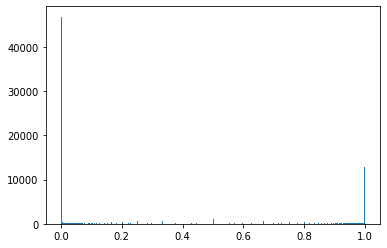

In [4]:
df_opp = dfs[0].copy()
#print(df_opp["reactions_weighted_YTA"].idxmin())
X, y, feat_name_lst = get_data_classes(df_opp, ratio=0.5, acros=acros, predict="ratio",judgement_weighted=True, mapping="opposite", verbose=True)    
train, test = train_test_split(range(124698), test_size=0.33, random_state=42)
X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]


#plt.hist(y[train], bins=10*32)
#plt.show()

oppoiste_y = y[train]

In [4]:
df_clip = dfs[0].copy()
X, y, feat_name_lst = get_data_classes(df_clip, ratio=0.5, acros=acros, predict="ratio",judgement_weighted=True, mapping="clip", verbose=True)    
print(range(len(X)))
train, test = train_test_split(range(len(X)), test_size=0.33, random_state=42)
X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]

clip_y = y[train]

#plt.hist(y[train], bins=10*32)
#plt.show()

df original shape (618203, 189)
Removed 493505 rows b.c. no votes. Now (124698, 190)
Removed 0 rows b.c. not enough agreement. Now (124698, 190)
(124698, 180)
range(0, 124698)


In [6]:
import pandas as pd
import numpy as np
from scipy import stats
y_clip = pd.read_csv("y_clip.csv").drop(columns=["Unnamed: 0"]).to_numpy().flatten()
y_opposite = pd.read_csv("y_opposite.csv").drop(columns=["Unnamed: 0"]).to_numpy().flatten()
print(y_clip.shape)
print(y_opposite.shape)
print(y_clip.sum())
print(y_opposite.sum())
stats.pearsonr(y_clip, y_opposite[:83547])
#np.corrcoef(y_clip, y_opposite)

(83547,)
(83547,)
23832.585573427223
24038.707803211913


(0.005407888612947739, 0.11802646684971047)

In [7]:
print(y_clip[:10])
print(y_opposite[:10])

[0.28571429 1.         0.66666667 0.92156863 0.         0.16666667
 0.1        0.6162963  0.28571429 0.45833333]
[0.5        0.6        0.         0.09090909 0.         0.88235294
 0.95774648 0.66666667 0.         0.        ]


In [5]:
df_n = pd.DataFrame(data=y[train])
df_n.to_csv("y_clip.csv")

(83547,)


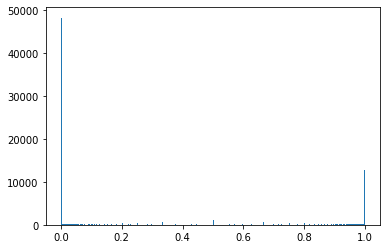

In [12]:
import matplotlib.pyplot as plt
print(y_clip.shape)
plt.hist(y_clip, bins=10*32)
plt.show()

(83766,)


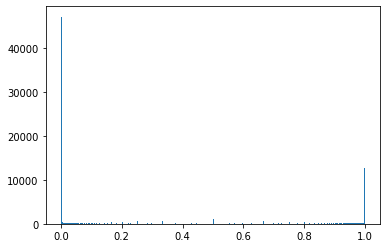

In [13]:
print(y_opposite.shape)
plt.hist(y_opposite, bins=10*32)
plt.show()

In [10]:
train, test = train_test_split(range(124698), test_size=0.33, random_state=42)
print(train[:10])

[94883, 123137, 60980, 94428, 50133, 27063, 89476, 71162, 54119, 75808]
